# 04 — Regression (Supervised) for PM2.5 (Tabular Time-Lag Features)
Mục tiêu:
- Biến bài toán chuỗi thời gian thành bài toán **hồi quy có giám sát**: dự đoán PM2.5(t+h) từ đặc trưng tại thời điểm t.
- Thấy rõ: **leakage** và vì sao phải split theo thời gian.
- So sánh tư duy hồi quy (feature-based) vs ARIMA (time-series-based).


In [1]:
from pathlib import Path

# ===== PARAMETERS =====
USE_UCIMLREPO = False

# Path to the raw ZIP (relative to project root)
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

def resolve_project_root(raw_zip_rel: str) -> Path:
    """Resolve project root robustly for both Jupyter and Papermill runs.

    Papermill may execute notebooks with different working directories depending on how you run the pipeline.
    This helper tries:
      1) current working directory
      2) parent directory
      3) up to 3 levels up (useful when running from notebooks/ or notebooks/runs)
    """
    cwd = Path.cwd().resolve()

    # Common candidates
    candidates = [cwd, cwd.parent]

    # Climb up a few levels just in case
    root = cwd
    for _ in range(3):
        candidates.append(root)
        root = root.parent

    for r in candidates:
        if (r / raw_zip_rel).exists():
            return r

    # Fallback: keep cwd; downstream will raise a clear error message if missing
    return cwd

PROJECT_ROOT = resolve_project_root(RAW_ZIP_PATH)
RAW_ZIP_ABS = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())

LAG_HOURS = [1, 3, 24]
HORIZON = 1              # dự đoán trước bao nhiêu giờ
TARGET_COL = 'PM2.5'

OUTPUT_REG_DATASET_PATH = 'data/processed/dataset_for_regression.parquet'
CUTOFF = '2017-01-01'

MODEL_OUT = 'regressor.joblib'
METRICS_OUT = 'regression_metrics.json'
PRED_SAMPLE_OUT = 'regression_predictions_sample.csv'


In [2]:
# Parameters
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
LAG_HOURS = [1, 3, 24]
HORIZON = 1
TARGET_COL = "PM2.5"
OUTPUT_REG_DATASET_PATH = "data/processed/dataset_for_regression.parquet"
CUTOFF = "2017-01-01"
MODEL_OUT = "regressor.joblib"
METRICS_OUT = "regression_metrics.json"
PRED_SAMPLE_OUT = "regression_predictions_sample.csv"


In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.classification_library import Paths
from src.regression_library import (
    run_prepare_regression_dataset,
    run_train_regression,
)

paths = Paths(project_root=PROJECT_ROOT)
print('PROJECT_ROOT =', PROJECT_ROOT)
print('RAW_ZIP_ABS =', RAW_ZIP_ABS)


PROJECT_ROOT = D:\KPDL\lab4\lab4
RAW_ZIP_ABS = D:\KPDL\lab4\lab4\data\raw\PRSA2017_Data_20130301-20170228.zip


## 1) Tạo dataset hồi quy (lag features + time features + y = PM2.5(t+h))
Trong lab, phần này giúp sinh viên hiểu cách tạo supervised dataset từ time series.

In [4]:
out_path = run_prepare_regression_dataset(
    paths=paths,
    use_ucimlrepo=USE_UCIMLREPO,
    raw_zip_path=RAW_ZIP_ABS,
    lag_hours=LAG_HOURS,
    horizon=HORIZON,
    target_col=TARGET_COL,
)
print('Saved:', out_path)


Saved: D:\KPDL\lab4\lab4\data\processed\dataset_for_regression.parquet


## 2) Quick EDA cho dataset hồi quy
Gợi ý câu hỏi ra quyết định:
- Tỉ lệ missing ở các feature lag? (thường thiếu ở đầu chuỗi)
- PM2.5 có phân phối lệch (skew) không? -> cân nhắc log/clip (tuỳ chọn)
- Có khác biệt theo *giờ trong ngày* / *ngày trong tuần* không? (seasonality)


(420768, 57)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24,y
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


CO_lag24     0.049849
CO_lag3      0.049284
CO_lag1      0.049227
CO           0.049198
O3_lag24     0.032203
O3_lag3      0.031640
O3_lag1      0.031583
O3           0.031554
NO2_lag24    0.029446
NO2_lag3     0.028881
NO2_lag1     0.028823
NO2          0.028795
SO2_lag24    0.022091
SO2_lag3     0.021525
SO2_lag1     0.021468
dtype: float64

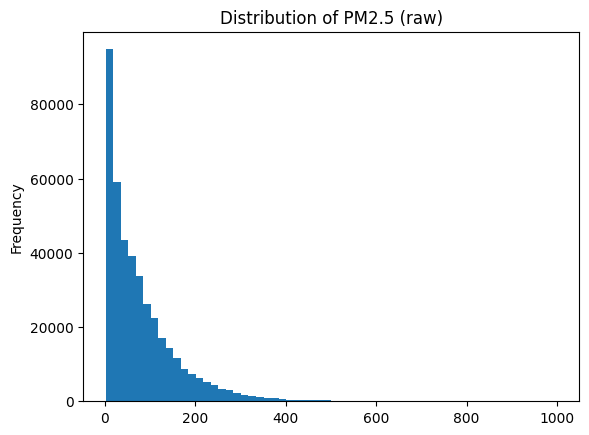

In [5]:
ds_path = (PROJECT_ROOT / OUTPUT_REG_DATASET_PATH).resolve()
df = pd.read_parquet(ds_path)
print(df.shape)
display(df.head())

missing = df.isna().mean().sort_values(ascending=False).head(15)
display(missing)

plt.figure()
pd.Series(df[TARGET_COL]).dropna().plot(kind='hist', bins=60)
plt.title(f'Distribution of {TARGET_COL} (raw)')
plt.show()


## 3) Train/Test theo thời gian + train regressor
Lưu ý: mô hình hồi quy ở đây là **feature-based** (dùng lag + thời tiết).
Phần dự báo chuỗi thời gian *thuần* sẽ làm bằng ARIMA ở notebook kế tiếp.

Metrics:
{
  "n_train": 395301,
  "n_test": 16716,
  "rmse": 25.32672696176382,
  "mae": 12.323158305172308,
  "smape_pct": 23.837711259945234,
  "r2": 0.949150877210564,
  "feature_cols": [
    "No",
    "year",
    "month",
    "day",
    "hour",
    "PM2.5",
    "PM10",
    "SO2",
    "NO2",
    "CO",
    "O3",
    "TEMP",
    "PRES",
    "DEWP",
    "RAIN",
    "wd",
    "WSPM",
    "station",
    "hour_sin",
    "hour_cos",
    "dow",
    "is_weekend",
    "PM2.5_lag1",
    "PM10_lag1",
    "SO2_lag1",
    "NO2_lag1",
    "CO_lag1",
    "O3_lag1",
    "TEMP_lag1",
    "PRES_lag1",
    "DEWP_lag1",
    "RAIN_lag1",
    "WSPM_lag1",
    "PM2.5_lag3",
    "PM10_lag3",
    "SO2_lag3",
    "NO2_lag3",
    "CO_lag3",
    "O3_lag3",
    "TEMP_lag3",
    "PRES_lag3",
    "DEWP_lag3",
    "RAIN_lag3",
    "WSPM_lag3",
    "PM2.5_lag24",
    "PM10_lag24",
    "SO2_lag24",
    "NO2_lag24",
    "CO_lag24",
    "O3_lag24",
    "TEMP_lag24",
    "PRES_lag24",
    "DEWP_lag24",
    "RAIN_lag24",

,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,477.0,436.901040
1,2017-01-01 01:00:00,Aotizhongxin,454.0,444.198916
2,2017-01-01 02:00:00,Aotizhongxin,418.0,433.323668
3,2017-01-01 03:00:00,Aotizhongxin,438.0,371.884739
4,2017-01-01 04:00:00,Aotizhongxin,453.0,464.841039


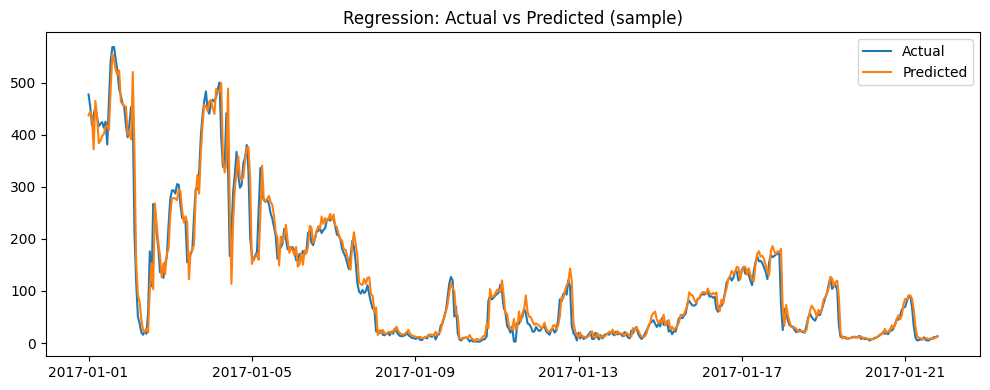

In [6]:
out = run_train_regression(
    paths=paths,
    cutoff=CUTOFF,
    model_out=MODEL_OUT,
    metrics_out=METRICS_OUT,
    preds_out=PRED_SAMPLE_OUT,
)

print('Metrics:')
print(json.dumps(out['metrics'], ensure_ascii=False, indent=2))
pred_df = out['pred_df']
display(pred_df.head())

# Plot a small window for storytelling
sample = pred_df.dropna().iloc[:500].copy()
plt.figure(figsize=(10,4))
plt.plot(sample['datetime'], sample['y_true'], label='Actual')
plt.plot(sample['datetime'], sample['y_pred'], label='Predicted')
plt.title('Regression: Actual vs Predicted (sample)')
plt.legend()
plt.tight_layout()
plt.show()


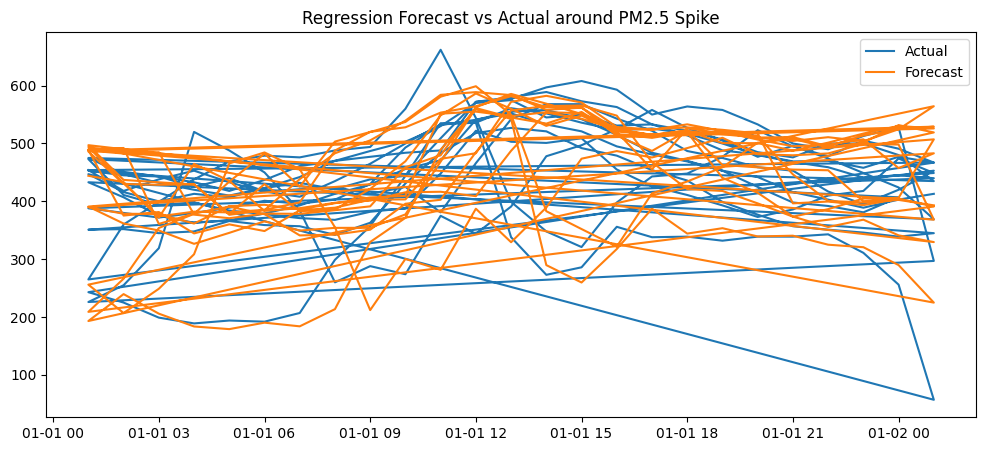

In [7]:

threshold = pred_df["y_true"].quantile(0.99)

spike_df = pred_df[pred_df["y_true"] >= threshold]

center_time = spike_df.iloc[0]["datetime"]

start = center_time - pd.Timedelta(hours=12)
end   = center_time + pd.Timedelta(hours=12)

mask = (pred_df["datetime"] >= start) & (pred_df["datetime"] <= end)

plt.figure(figsize=(12,5))
plt.plot(pred_df.loc[mask, "datetime"], pred_df.loc[mask, "y_true"], label="Actual")
plt.plot(pred_df.loc[mask, "datetime"], pred_df.loc[mask, "y_pred"], label="Forecast")
plt.legend()
plt.title("Regression Forecast vs Actual around PM2.5 Spike")
plt.show()
